#Gather trajectories

In [10]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_transformed = map( lambda x: x-width/2 , x_raw )
y_transformed = map( lambda x: -height/2-x , y_raw )
domain = (-width/2,width/2,-height/2,height/2)

width = 1980.000000, height = 1093.000000


In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

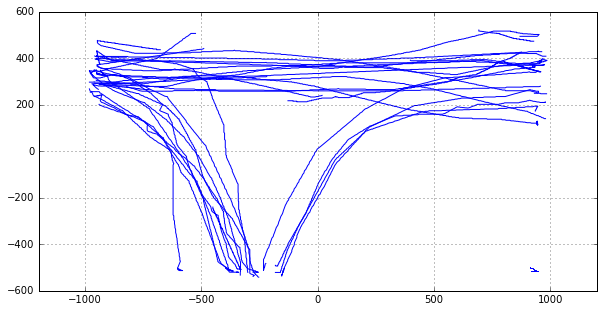

In [12]:
plt.figure(figsize=(10,5))
for k in range(len(x_transformed)):
    plt.plot(x_transformed[k],y_transformed[k],'b-')
plt.axis(domain)
plt.grid()
plt.axis('equal')
plt.show()

## Lagrangian
We consider Lagrangian's of the form
$$
    L(x,y,\dot{x},\dot{y};\theta) = \frac{1}{2} ( \dot{x}^2+\dot{y}^2) - (\partial_y \phi(x,y;\theta) \dot{x} - \partial_x \phi(x,y;\theta) \dot{y} )
$$
where
$$
    \phi(x,y;\theta) = \sum_{k_1,k_2} \theta_{k_1,k_2} H_{k_1}(\alpha_x x)H_{k_2}(\alpha_y y).
$$
The Euler-Lagrange equations are given by
$$
    \frac{d}{dt} \left(\dot{x} - \partial_y \phi \right) + \partial_{xy} \phi \dot{x} - \partial_{xx}\phi \dot{y} = 0 \\
    \frac{d}{dt} \left(\dot{y} + \partial_x \phi \right) + \partial_{yy} \phi \dot{x} - \partial_{xy}\phi \dot{y} = 0
$$
which simplifies to
$$
    \ddot{x} = \Delta \phi(x,y) \dot{y} \\
    \ddot{y} = -\Delta \phi(x,y) \dot{x}
$$
where $\Delta = \partial_{xx} + \partial_{yy}$


## Cost function
For any two points $x_0,x_T$ we let $x(t;\theta)$ denote the curve on $[0,T]$ which minimizes the action
$$
    S[x;\theta] := \int_0^T L( x,\dot{x} ; \theta) dt
$$
In otherwords, $x( \cdot \,;\theta) = {\rm argmin}_y( S[y;\theta] ) $.
Our goal is to learn the parameters, $\theta$.
Given a single curve $X:[0,T]\to D$, the cost function for our learning algorithm will be
$$
    C(\theta) = \frac{1}{2} \int_0^T \| X(t) - x(t;X_0,X_T,\theta) \|^2 dt
$$
so that the gradient is
$$
    dC(\theta) = - \int \langle X(t) - x(t;\theta) , \delta_\theta x(t;\theta) \rangle dt
$$
where $\delta_\theta x(t;\theta)$ solves the boundary value problem
$$
    \ddot{x} = - \nabla V(x;\theta) \quad , \frac{d^2}{dt^2} \delta_\theta x = - \delta_\theta \nabla V(x;\theta) \delta_\theta x
$$
with the boundary conditions $x(0),x(T)$ given and $\delta_\theta x(0) = \delta_\theta x(T) = 0$.

##Collocation method
Let's solve the nonlinear optimization problem:
Minimize
$$
    C(\theta,q) = \sum_{t = 0}^{N} \| q_{\rm obs}(t) - q(t) \|^2
$$
subject to the constraint $q(0) = q_{\rm obs}(0),q(N) = q_{\rm obs}(N)$ fixed and
$$
    \frac{q(i-1) - 2 q(i) + q(i+1)}{(\Delta t)^2} + \begin{pmatrix} -1 \\ 1 \end{pmatrix} \Delta \phi( q(i) ) = 0.
$$
for $i=1,\dots,N-1$ with $\Delta t = \frac{1}{N}\sum_{i=0}^{N-1}\| q_{\rm obs}(i) - q_{\rm obs}(i+1) \|$

In [13]:
curves = []
curves.append( np.vstack( [x_transformed[0][460:800:10], y_transformed[0][460:800:10]] ) )
curves.append( np.vstack( [ x_transformed[4][230:510:10],y_transformed[4][230:510:10] ] ) )
curves.append( np.vstack( [ x_transformed[6][290:580:10],y_transformed[6][290:580:10] ] ) )
curves.append( np.vstack( [ x_transformed[13][170:300:10],y_transformed[13][170:300:10] ] ) )
curves.append( np.vstack( [ x_transformed[14][420:580:10], y_transformed[14][420:580:10] ] ) )
curves.append( np.vstack( [ x_transformed[15][50:200:10],y_transformed[15][50:200:10] ] ) )
curves.append( np.vstack( [ x_transformed[17][400:680:10],y_transformed[17][400:680:10] ] ) )
curves.append( np.vstack( [ x_transformed[20][200:400:10],y_transformed[20][200:400:10] ] ) )
#curves.append( np.vstack( [ x_transformed[22][370:650:10],y_transformed[22][370:650:10] ] ) )
curves.append( np.vstack( [ x_transformed[24][350:650:10],y_transformed[24][350:650:10] ] ) )

#time_scale = np.ones( len(curves))
def get_time_scale(c):
    x = c[0,:]
    y = c[1,:]
    dx = x[1:] - x[0:len(x)-1]
    dy = y[1:] - y[0:len(y)-1]
    return (np.sqrt(dx**2 + dy**2)).sum() / float(len(dx))

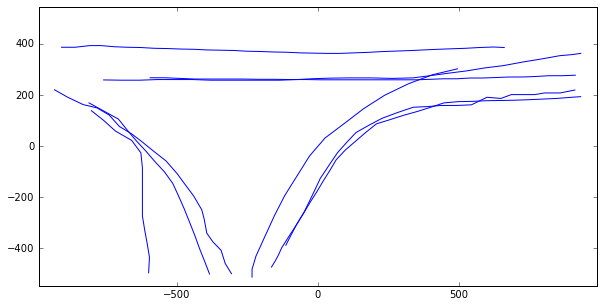

In [14]:
plt.figure(figsize=(10,5))
for c in curves:
    plt.plot(c[0,:],c[1,:],'b-')
plt.axis(domain)
plt.show()

In [31]:
def get_xy_theta(decision_variables, curves , k_max ):
    x_list = []
    y_list = []
    ref = 0
    for curve in curves:
        n = curve.shape[1] #number of collocation points
        x_list.append( decision_variables[ref:ref+n] )
        y_list.append( decision_variables[ref+n:ref+2*n] )
        ref += 2*n
    theta = decision_variables[ ref:].reshape( (k_max+1,k_max+1) )
    return x_list,y_list,theta

def cost_function(decision_variables, curves , k_max ):
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out = 0.
    for x,y,c in zip( x_list, y_list, curves):
        out += np.dot(x-c[0],x-c[0]) + np.dot(y-c[1],y-c[1])
    return out

def EL_constraint(decision_variables , curves, k_max ):
    global width,height
    from scipy import sparse
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out_list = []
    k = np.arange(-k_max , k_max+1)
    for k,(x,y) in enumerate(zip(x_list,y_list)):
        n = x.size
        Delta_t = get_time_scale( curves[k] )
        A_matrix = sparse.diags([np.ones(n-2),-2*np.ones(n-1),np.ones(n-2)],
                            offsets=[0,1,2], shape=(n-2,n) ) / (Delta_t**2)
        a_x = A_matrix.dot( x)
        a_y = A_matrix.dot( y)
        from numpy.polynomial.hermite import hermder, hermval2d
        theta_xx = hermder( theta, m=2, axis=0 )
        theta_yy = hermder( theta, m=2, axis=1 )
        alpha_x = np.sqrt(2*k_max) / (width/2)
        alpha_y = np.sqrt(2*k_max) / (height/2)
        phi_xx = (alpha_x**2)*hermval2d( alpha_x*x[1:n-1], alpha_y*y[1:n-1], theta_xx )
        phi_yy = (alpha_y**2)*hermval2d( alpha_x*x[1:n-1], alpha_y*y[1:n-1], theta_yy )
        out_list += [a_x-phi_xx-phi_yy, a_y+phi_xx+phi_yy]
    return np.hstack( out_list )

def boundary_constraint(decision_variables , curves , k_max):
    x_list,y_list,_ = get_xy_theta( decision_variables, curves, k_max)
    n_curves = len(curves)
    out = np.zeros( (4,n_curves) )
    for k,(x,y) in enumerate( zip(x_list,y_list) ):
        out[0][k] = curves[k][0,0] - x[0]
        out[1][k] = curves[k][0,-1] - x[-1]
        out[2][k] = curves[k][1,0] - y[0]
        out[3][k] = curves[k][1,-1] - y[-1]
    return out.flatten()

k_max = 3
constraint_list = []
constraint_list.append({'type':'eq', 'fun':EL_constraint, 'args':(curves,k_max)} )
constraint_list.append({'type':'eq', 'fun':boundary_constraint, 'args':(curves,k_max) } )

theta = np.zeros( (k_max+1, k_max+1) )
guess_list = []
for c in curves:
    x_guess = np.linspace(c[0,0],c[0,-1], len(c[0]))
    y_guess = np.linspace(c[1,0],c[1,-1], len(c[1]))
    guess_list += [x_guess,y_guess]
initial_guess = np.hstack( guess_list + [theta.flatten(),] )

def cb_function(x):
    global k_max,curves
    print "Cost = %f" % cost_function(x, curves , k_max )
    return 0

#x_out,y_out,theta_out = get_xy_theta( initial_guess , curves, k_max)
#plt.plot(x_out[0],y_out[0])
#plt.plot(curves[0][0,:],curves[0][1,:])
#print theta_out
#print cost_function(initial_guess, curves, k_max)
#print EL_constraint(initial_guess, curves, k_max)
#print boundary_constraint(initial_guess, curves, k_max)
#print cb_function(initial_guess)

In [32]:
from scipy.optimize import minimize
res = minimize( cost_function , initial_guess , constraints=constraint_list , args = (curves, k_max ),
              callback = cb_function)
print res.message
x_list,y_list,theta_opt_magnetic = get_xy_theta( res.x , curves, k_max)

Cost = 2243053.542910
Cost = 421676.684236
Cost = 420211.045724
Cost = 419570.078765
Cost = 419658.618476
Cost = 419647.159161
Cost = 419647.083626
Cost = 419647.067212
Cost = 419647.066975
Cost = 419647.066922
Cost = 419647.066941
Cost = 419647.066904
Cost = 419647.066929
Cost = 419647.066917
Cost = 419647.066921
Cost = 419647.066916
Cost = 419647.067037
Optimization terminated successfully.


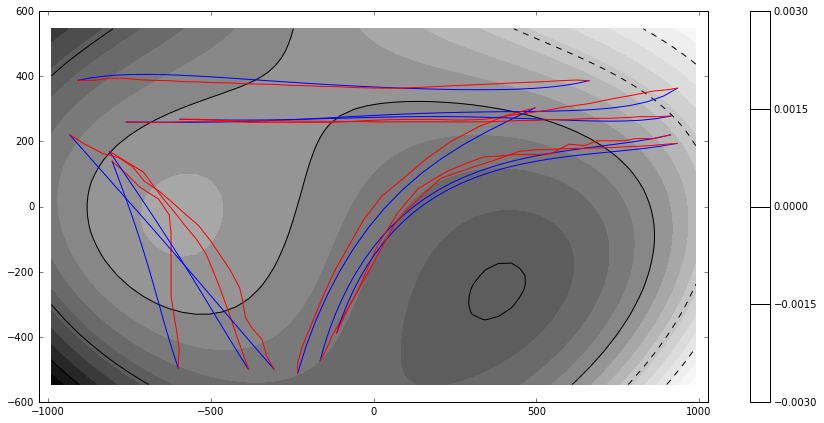

In [33]:
x_grid,y_grid = np.meshgrid( np.linspace(-width/2,width/2,50) , np.linspace(-height/2,height/2,50))
sigmoid = lambda x: 1.0/(1.0+np.exp(-x)) - 0.5
n_curves = len(curves)
from numpy.polynomial.hermite import hermval2d, hermder
alpha_x = np.sqrt(2*k_max) / (width/2)
alpha_y = np.sqrt(2*k_max) / (height/2)
theta_xx = hermder(theta_opt_magnetic,axis=0,m=2)
theta_yy = hermder(theta_opt_magnetic,axis=1,m=2)
B = alpha_x**2 * hermval2d(alpha_x*x_grid , alpha_y*y_grid, theta_xx)\
    + alpha_y**2 * hermval2d(alpha_x*x_grid, alpha_y*y_grid, theta_yy)
fig = plt.figure(figsize=(15,7))
plt.contourf(x_grid, y_grid, sigmoid(300*B) , 20,cmap='Greys')
plt.contour(x_grid, y_grid, B , colors='k')
plt.colorbar()
for k in range(n_curves):
    plt.plot(x_list[k],y_list[k], 'b-')
    plt.plot(curves[k][0,:] , curves[k][1,:],'r-')
axis_size= plt.axis('equal')

In [34]:
np.save('theta_opt_magnetic',theta_opt_magnetic)

## Sanity check
Let's see if we can reproduce the blue curves in the above plot using Stormer Verlet.

In [35]:
theta_opt_magnetic = np.load('theta_opt_magnetic.npy')
k_max = theta_opt_magnetic.shape[0]-1
alpha_x = np.sqrt(2*k_max) / (width/2)
alpha_y = np.sqrt(2*k_max) / (height/2)
from numpy.polynomial.hermite import hermval2d, hermder
theta_xx = hermder(theta_opt_magnetic,axis=0,m=2)
theta_yy = hermder(theta_opt_magnetic,axis=1,m=2)

In [36]:
def Stormer_Verlet(x0,x1,y0,y1,Delta_t,n_steps):
    global alpha_x,alpha_y, theta_xx, theta_yy
    from numpy.polynomial.hermite import hermder
    theta_xx = hermder( theta_opt_magnetic, axis=0, m=2)
    theta_yy = hermder( theta_opt_magnetic, axis=1, m=2)
    x_pred = [x0,x1]
    y_pred = [y0,y1]
    for _ in range(2,n_steps):
        x0,x1 = x_pred[-2], x_pred[-1]
        y0,y1 = y_pred[-2], y_pred[-1]
        phi_xx = (alpha_x**2)*hermval2d(alpha_x*x1 , alpha_y*y1, theta_xx )
        phi_yy = (alpha_y**2)*hermval2d(alpha_x*x1 , alpha_y*y1, theta_yy )
        x_pred.append( 2*x1 - x0 + Delta_t**2 * (phi_xx+phi_yy) )
        y_pred.append( 2*y1 - y0 - Delta_t**2 * (phi_xx+phi_yy) )
    return np.array(x_pred),np.array(y_pred)

def EL_ode(state,t):
    global alpha_x, alpha_y, theta_xx, theta_yy
    x,y,u,v = tuple(state)
    phi_xx = (alpha_x**2)*hermval2d(alpha_x*x , alpha_y*y, theta_xx )
    phi_yy = (alpha_y**2)*hermval2d(alpha_x*x , alpha_y*y, theta_yy )
    return np.array([u,v,phi_xx+phi_yy,-phi_xx-phi_yy])
    

In [37]:
curve_ind = 4
x0,x1 = x_list[curve_ind][0], x_list[curve_ind][1]
y0,y1 = y_list[curve_ind][0], y_list[curve_ind][1]
Delta_t = get_time_scale( curves[curve_ind] )#np.sqrt( (x1-x0)**2 + (y1-y0)**2 )
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1, Delta_t, len(curves[curve_ind][0,:]) )

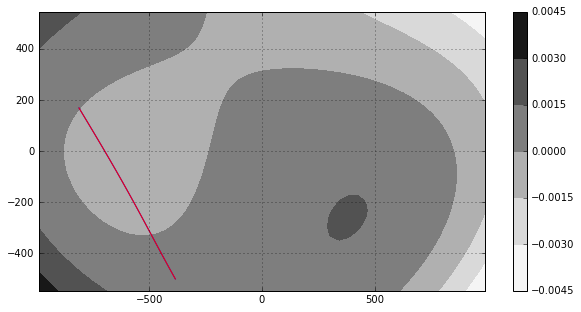

In [38]:
plt.figure(figsize = (10,5))
cs=plt.contourf(x_grid,y_grid,B , 5,cmap='Greys')
plt.colorbar(cs)
plt.plot(x_list[curve_ind],y_list[curve_ind],'b-')
plt.plot(x_pred,y_pred,'r-')
plt.axis([-width/2,width/2,-height/2,height/2])
plt.grid(True)
plt.show()

## Predictions from Training Data
Now let's see if we can predict some of the red curves in the training data using a finite difference scheme to estimate the initial velocity

In [39]:
start = 1
x0 = curves[curve_ind][0,start]
x1 = x0 + 0.5*( curves[curve_ind][0,start+1] - curves[curve_ind][0,start-1] )
y0= curves[curve_ind][1,start]
y1 = y0 + 0.5*( curves[curve_ind][1,start+1] - curves[curve_ind][1,start-1] )
Delta_t = np.sqrt( (x1-x0)**2 + (y1-y0)**2 )
t_max = len(curves[curve_ind][0,:])-start
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,Delta_t,t_max)

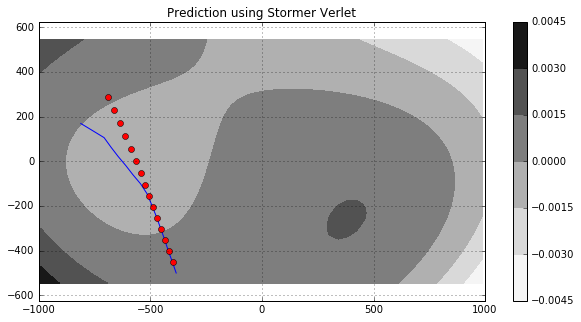

In [40]:
plt.figure(figsize = (10,5))
cs=plt.contourf(x_grid,y_grid,B , 5,cmap='Greys')
plt.colorbar(cs)
plt.plot(curves[curve_ind][0],curves[curve_ind][1],'b-')
plt.plot(x_pred,y_pred,'ro')
#plt.axis([-width/2,width/2,-height/2,height/2])
plt.axis('equal')
plt.grid(True)
plt.title('Prediction using Stormer Verlet')

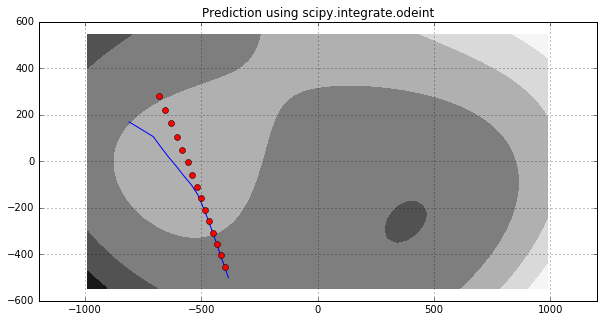

In [41]:
start = 1
x0 = curves[curve_ind][0,start]
u0 = 0.5*( curves[curve_ind][0,start+1] - curves[curve_ind][0,start-1] )
y0 = curves[curve_ind][1,start]
v0 = 0.5*( curves[curve_ind][1,start+1] - curves[curve_ind][1,start-1] )
speed = np.sqrt( u0**2 + v0**2 )
u0 = u0 / speed
v0 = v0 / speed
state_0 = np.array([x0,y0,u0,v0])
from scipy.integrate import odeint
n_steps = len(curves[curve_ind][0,:])-start
state_arr = odeint( EL_ode, state_0, speed*np.arange(n_steps))
x_pred = state_arr[:,0]
y_pred = state_arr[:,1]
plt.figure(figsize = (10,5))
plt.contourf(x_grid,y_grid,B , 5,cmap='Greys')
plt.plot(curves[curve_ind][0],curves[curve_ind][1],'b-')
plt.plot(x_pred,y_pred,'ro')
plt.title('Prediction using scipy.integrate.odeint')
plt.axis('equal')
plt.grid(True)

## Predictions on Test data
Let's do the same thing on some of the test data

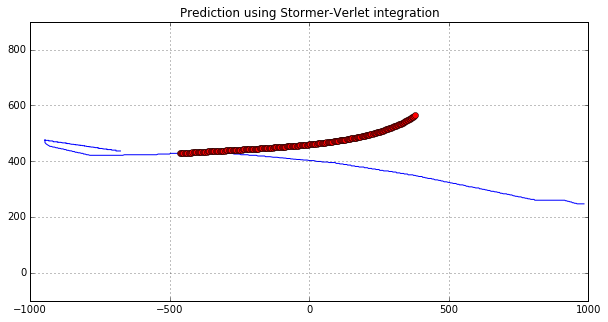

In [50]:
curve_ind = 9
start = 600
x0 = x_transformed[curve_ind][start]
x1 = x0 + ( x_transformed[curve_ind][start+3] - x_transformed[curve_ind][start-3] ) / float(6)
y0 = y_transformed[curve_ind][start]
y1 = y0 + ( y_transformed[curve_ind][start+3] - y_transformed[curve_ind][start-3] ) / float(6)
Delta_t = np.sqrt( (x1-x0)**2 + (y1-y0)**2)
t_max = 200 #len(curves[curve_ind][0,:])-start
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,Delta_t,t_max)
fig = plt.figure(figsize=(10,5))
plt.plot(x_transformed[curve_ind], y_transformed[curve_ind],'b-')
plt.plot(x_pred,y_pred,'ro')
#plt.axis([-width/2,width/2,-height/2,height/2])
plt.title('Prediction using Stormer-Verlet integration')
plt.axis('equal')
plt.grid(True)

4.59543855965


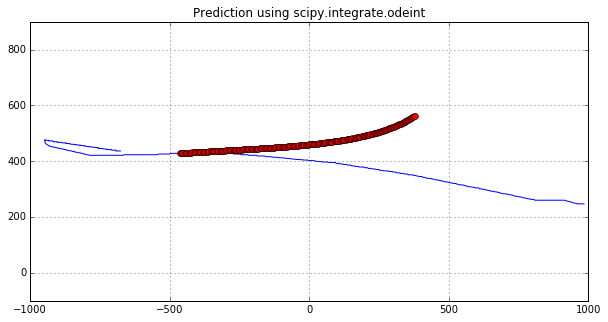

In [51]:
x0 = x_transformed[curve_ind][start]
u0 = ( x_transformed[curve_ind][start+3] - x_transformed[curve_ind][start-3] ) / float(6)
y0 = y_transformed[curve_ind][start]
v0 = ( y_transformed[curve_ind][start+3] - y_transformed[curve_ind][start-3] ) / float(6)

speed = np.sqrt( u0**2 + v0**2 )
print speed
u0 = u0 / speed
v0 = v0 / speed

state_0 = np.array([x0,y0,u0,v0])
from scipy.integrate import odeint
n_steps = 200
state_arr = odeint( EL_ode, state_0, speed*np.arange(n_steps))
x_pred = state_arr[:,0]
y_pred = state_arr[:,1]
plt.figure(figsize = (10,5))
plt.plot(x_transformed[curve_ind], y_transformed[curve_ind],'b-')
plt.plot(x_pred,y_pred,'ro')
plt.title('Prediction using scipy.integrate.odeint')
plt.axis('equal')
plt.grid(True)